In [1]:
import emoji # Extract and analyze emojis from messages
import datetime # Date type conversions
import re # Used to count words in each message
import polars as pl # Dataframe library (alternative to pandas)
import numpy as np # Numpy arrays 

# Seaborn is a Data Viz library built on top of matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick


%matplotlib inline
%reload_ext autoreload
%autoreload 2
sns.set_palette("muted")


In [2]:
# Use readlines() to read the raw WhatsApp messages into a list of strings
file1 = open('gab_chat.txt', 'r', encoding = 'utf-8')
Lines = file1.readlines()
raw_lines = [line for line in Lines]

# First two items in raw_lines:
# [8/11/2021, 9:36:48 pm] Dyl: Hi Gab!
# [8/11/2021, 10:16:52 pm] Gab: Hey Dylan how’s it going ?

In [3]:
# This function is applied to the raw input lines to drop unwanted and/or system messages 
def filter_raw_lines(raw_lines):
    lines_to_keep = []
    # First line is a system message from WhatsApp, drop it with "[1:]" splice
    for line in raw_lines[1:]:
        # Remove system messages, gifs/images and forwarded messages with "str.startswith(line, '[')"
        if (str.startswith(line, '[') and "Missed video call" not in line and "Missed voice call" not in line and "GIF omitted" not in line and "image omitted" not in line):
            lines_to_keep.append(line)

    return lines_to_keep
                                            
# This function parses the message content and metadata out into separate components
def parse_line_contents(line):
    split_line = line.split('] ', 1)
    date_str = split_line[0][1:].split(',')[0]
    # Note: dropping hour/minute/sec information from this point on
    date = datetime.datetime.strptime(date_str, '%d/%m/%Y')

    author = split_line[1].split(': ', 1)[0]
    message = split_line[1].split(': ', 1)[1].strip()
    
    return [date, author, message]
    

In [4]:
filtered_lines = filter_raw_lines(raw_lines)
parsed_lines = [parse_line_contents(line) for line in filtered_lines]

messages = pl.DataFrame(data = parsed_lines, schema = {'datetime': 'datetime', 'author': 'str', 'message': 'str'})
messages = messages.with_columns(pl.col("datetime").cast(pl.Date).alias("date"))

# Filter the messages dataframe to only have the first full 12 months of data (Dec 2021 to Nov 2022)
filtered_messages = messages.filter(
    pl.col("date").is_between(
        datetime.datetime.strptime('2021-12-01', '%Y-%m-%d'),
        datetime.datetime.strptime('2022-11-30', '%Y-%m-%d'))
)
filtered_messages.head(5)

datetime,author,message,date
datetime[μs],str,str,date
2021-12-01 00:00:00,"""Dyl""","""Hiya""",2021-12-01
2021-12-01 00:00:00,"""Dyl""","""What time shou…",2021-12-01
2021-12-01 00:00:00,"""Gab""","""6.30 ish ?""",2021-12-01
2021-12-01 00:00:00,"""Gab""","""It’s so warm t…",2021-12-01
2021-12-01 00:00:00,"""Gab""","""I just want to…",2021-12-01


In [5]:
prepped = filtered_messages.with_columns(
    pl.col('message').apply(lambda msg: emoji.emoji_count(msg)).alias('emoji_count'),
    pl.col('message').apply(lambda msg: len(re.findall(r'\w+', msg))).alias('word_count'),
    pl.col('message').apply(lambda msg: [match['emoji'] for match in emoji.emoji_list(msg)]).alias('emoji_list'),
    pl.col('date').dt.strftime("%b").alias("month"),
    pl.col('date').dt.strftime("%a").alias("day")
)

# Because I want a full 12 months of data only, but we are not in a complete calendar year
# we need to do some hacky stuff to get the December month as first in the ordering
# 0 = Dec 21, 1 = Jan 22, 11 = Nov 22
months_order = ['Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov']
months_order_dict = {val: idx for idx, val in enumerate(months_order)}
prepped = prepped.with_columns(
    pl.col('month').apply(lambda mon: months_order_dict[mon]).alias('month_index')
)

prepped.tail(7)


datetime,author,message,date,emoji_count,word_count,emoji_list,month,day,month_index
datetime[μs],str,str,date,i64,i64,list[str],str,str,i64
2022-11-30 00:00:00,"""Dyl""","""But i dont thi…",2022-11-30,0,13,[],"""Nov""","""Wed""",11
2022-11-30 00:00:00,"""Gab""","""🥹🥹""",2022-11-30,2,0,"[""🥹"", ""🥹""]","""Nov""","""Wed""",11
2022-11-30 00:00:00,"""Dyl""","""Is okey i thin…",2022-11-30,0,9,[],"""Nov""","""Wed""",11
2022-11-30 00:00:00,"""Dyl""","""Tofu is taking…",2022-11-30,0,6,[],"""Nov""","""Wed""",11
2022-11-30 00:00:00,"""Gab""","""I’ll come down…",2022-11-30,0,7,[],"""Nov""","""Wed""",11
2022-11-30 00:00:00,"""Gab""","""I alrdy finish…",2022-11-30,0,3,[],"""Nov""","""Wed""",11
2022-11-30 00:00:00,"""Gab""","""Ughhhh""",2022-11-30,0,1,[],"""Nov""","""Wed""",11


[Text(0, 0, '10820'), Text(0, 0, '10090')]

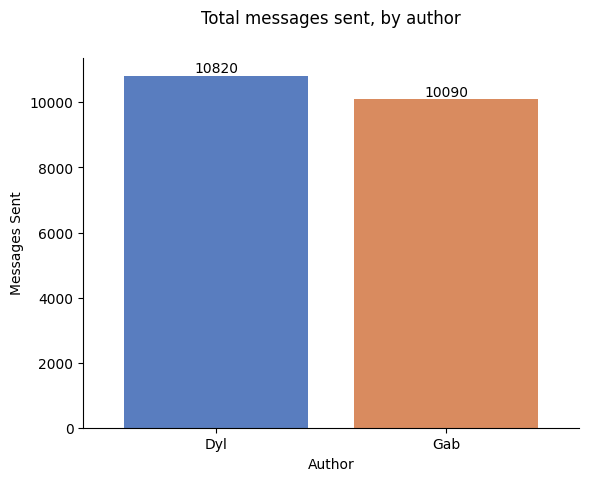

In [6]:
# 1. Total messages, total emojis (split by person) [Vertical Bar] 
df1 = prepped.with_columns(pl.lit(1).alias("messages_count")).to_pandas()


g1 = sns.barplot(
    data=df1,
    x='author',
    y='messages_count',
    estimator=sum,
    errorbar=None
)
sns.despine()
plt.margins(x=0.1)

g1.set_ylabel("Messages Sent")
g1.set_xlabel("Author")
g1.set_title("Total messages sent, by author", pad=25)
g1.bar_label(g1.containers[0])

[Text(0, 0, '671'), Text(0, 0, '1516')]

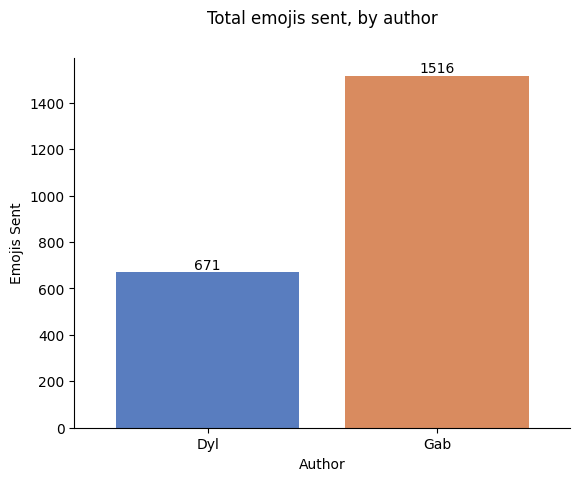

In [7]:
# 2. Total emojis (split by person) [Vertical Bar] 
df2 = prepped.to_pandas()

g2 = sns.barplot(
    data=df2,
    x='author',
    y='emoji_count',
    estimator=sum,
    errorbar=None
)
sns.despine()
plt.margins(x=0.1)

g2.set_ylabel("Emojis Sent")
g2.set_xlabel("Author")
g2.set_title("Total emojis sent, by author", pad=25)
g2.bar_label(g2.containers[0])

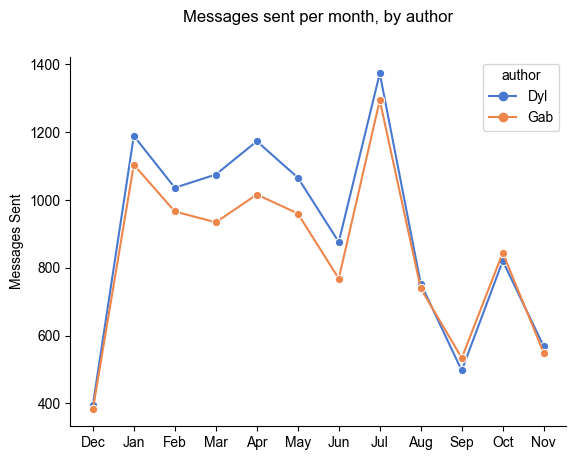

In [8]:
# 3. Messages sent (per month, split by author) [Line]

df3 = prepped.groupby(["month_index", "author"]).agg(pl.count().alias('num_messages')).sort("month_index")

g3 = sns.lineplot(
    data=df3,
    x='month_index',
    y='num_messages',
    hue='author',
    markers=["o", "o"],
    dashes=False,
    hue_order=['Dyl', 'Gab'],
        style='author'


)
#g3.legend_.remove()
g3.set_xticks(range(12))
g3.set_xticklabels(months_order)
g3.set_xlabel("")
g3.set_ylabel("Messages Sent")
g3.set_title("Messages sent per month, by author", pad=25)

sns.set_style("white")
sns.despine()

plt.show(g3)


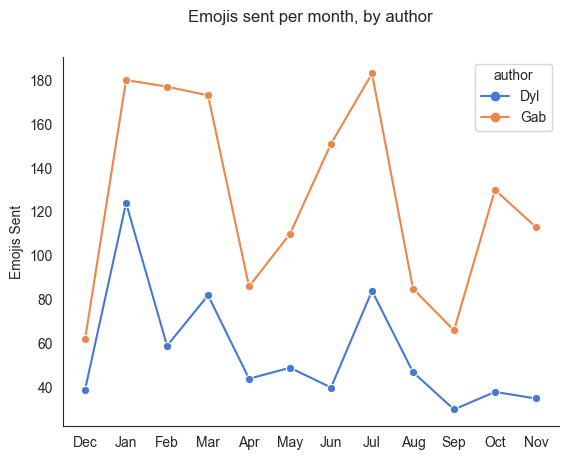

In [9]:
# 4. Emojis sent (per month, split by author) [Line]

df4 = prepped.groupby(["month_index", "author"]).agg(pl.sum('emoji_count').alias('num_emojis')).sort("month_index")

g4 = sns.lineplot(
    data=df4,
    x='month_index',
    y='num_emojis',
    hue='author',
    hue_order=['Dyl', 'Gab'],
    markers=["o", "o"],
    dashes=False,
    style='author'

)

sns.despine()

g4.set_xticks(range(12))
g4.set_xticklabels(months_order)
g4.set_xlabel("")
g4.set_ylabel("Emojis Sent")
g4.set_title("Emojis sent per month, by author", pad=25)


plt.show(g4)

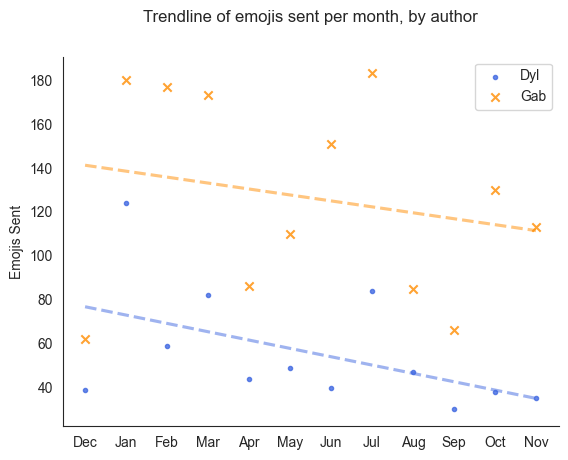

In [38]:
# 4. Emojis sent (per month, split by author) [Trend]

g4reg, ax = plt.subplots() 
colors = ['royalblue', 'darkorange']
markers = ['.', 'x']

for i, value in enumerate(["Dyl", "Gab"]):
    ax = sns.regplot(x="month_index", y="num_emojis", ax=ax,
                     color=colors[i],
                     ci=None,
                     line_kws={'alpha':0.5, 'linestyle':'--'},
                     marker=markers[i], 
                     data=df4.filter(pl.col("author") == value),
                     label=value)

ax.legend(loc='best') 
ax.set_xticks(range(12))
ax.set_xticklabels(months_order)
ax.set_xlabel("")
ax.set_ylabel("Emojis Sent")
ax.set_title("Trendline of emojis sent per month, by author", pad=25)

sns.despine()

display(g4reg) 

plt.close('all')

In [39]:
# Calculate Emojis per message  (per month, split by author) [Line]

emojis_per_msg_df = prepped.groupby(["month_index", "author"]).agg([
    pl.sum('emoji_count').alias('num_emojis'),
    pl.count().alias('num_messages'),
    (pl.sum('emoji_count') / pl.count()).alias("num_emojis_per_message"),
]).sort(["month_index", "author"])


emojis_per_msg_df.head(10)

month_index,author,num_emojis,num_messages,num_emojis_per_message
i64,str,i64,u32,f64
0,"""Dyl""",39,394,0.098985
0,"""Gab""",62,382,0.162304
1,"""Dyl""",124,1189,0.104289
1,"""Gab""",180,1104,0.163043
2,"""Dyl""",59,1036,0.05695
2,"""Gab""",177,966,0.18323
3,"""Dyl""",82,1075,0.076279
3,"""Gab""",173,934,0.185225
4,"""Dyl""",44,1173,0.037511


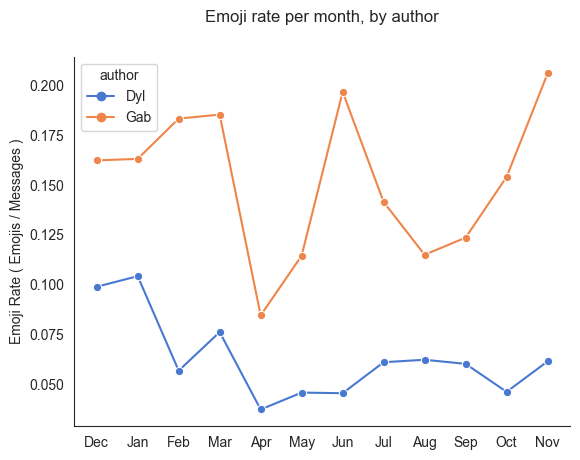

In [40]:
# 5. Emojis per message rate (per month, split by author) [Line]

g5 = sns.lineplot(
    data=emojis_per_msg_df,
    x='month_index',
    y='num_emojis_per_message',
    hue='author',
    hue_order=['Dyl', 'Gab'],
    markers=["o", "o"],
    dashes=False,
    style='author'

)

sns.despine()

g5.set_xticks(range(12))
g5.set_xticklabels(months_order)
g5.set_xlabel("")
g5.set_ylabel("Emoji Rate ( Emojis / Messages )")
g5.set_title("Emoji rate per month, by author", pad=25)


plt.show(g5)

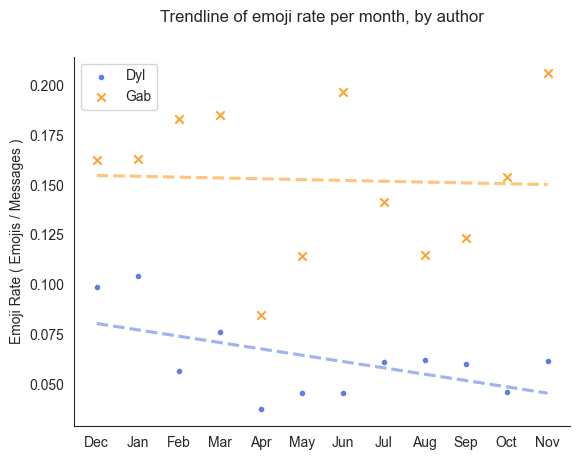

In [42]:
# 6. Emojis per message rate (per month, split by author) [Trend]

g6reg, ax = plt.subplots() 
colors = ['royalblue', 'darkorange']
markers = ['.', 'x']

for i, value in enumerate(["Dyl", "Gab"]):
    ax = sns.regplot(x="month_index", y="num_emojis_per_message", ax=ax,
                     color=colors[i],
                     ci=None,
                     line_kws={'alpha':0.5, 'linestyle':'--'},
                     marker=markers[i], 
                     data=emojis_per_msg_df.filter(pl.col("author") == value),
                     label=value)

ax.legend(loc='best') 
ax.set_xticks(range(12))
ax.set_xticklabels(months_order)
ax.set_xlabel("")
ax.set_ylabel("Emoji Rate ( Emojis / Messages )")
sns.despine()
ax.set_title("Trendline of emoji rate per month, by author", pad=25)

display(g6reg) 

plt.close('all')

In [43]:
#8 Table showing emoji rate per month, by author
emoji_rate_table = emojis_per_msg_df.pivot(index="author", columns="month_index", values="num_emojis_per_message", aggregate_function="sum")
inv_months_order_dict = {str(v): k for k, v in months_order_dict.items()}
emoji_rate_table = emoji_rate_table.rename(inv_months_order_dict)

emoji_rate_table

author,Dec,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""Dyl""",0.098985,0.104289,0.05695,0.076279,0.037511,0.045966,0.045662,0.06118,0.062417,0.060362,0.046341,0.06162
"""Gab""",0.162304,0.163043,0.18323,0.185225,0.084646,0.114583,0.196615,0.141422,0.11502,0.123596,0.154028,0.205829


In [44]:
#9 Table showing emojis sent per 10 messages - per month, by author

# Please don't look at the below code lol
author_col = emoji_rate_table.select(pl.col("author"))
emoji_rate_by_10_cols = emoji_rate_table.drop("author").select([
    pl.all().apply(lambda x: x*10)
])
emoji_rate_per_10_messages_table = pl.concat([author_col, emoji_rate_by_10_cols], how="horizontal")
emoji_rate_per_10_messages_table


author,Dec,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""Dyl""",0.989848,1.042893,0.569498,0.762791,0.375107,0.459662,0.456621,0.611799,0.62417,0.603622,0.463415,0.616197
"""Gab""",1.623037,1.630435,1.832298,1.852248,0.846457,1.145833,1.966146,1.414219,1.150203,1.235955,1.540284,2.058288


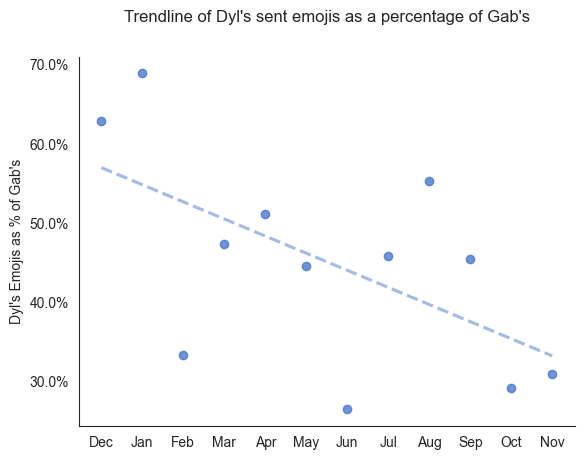

In [45]:
#10. Dyl's emojis as a percentage of gabs (per month) [Trend]

df7 = prepped.groupby(["month_index", "author"]).agg(pl.sum('emoji_count').alias('num_emojis')).sort(["month_index", "author"])
df7_piv = df7.pivot(index="author", columns="month_index", values="num_emojis", aggregate_function="sum")
gab_emojis = np.array(df7_piv.row(1)[1:])
dyl_emojis = np.array(df7_piv.row(0)[1:])
df7_final = pl.DataFrame((dyl_emojis / gab_emojis) * 100, schema = {'dyl_emoji_ratio': 'f64'}).with_columns(pl.Series(name="month_index", values=range(12)))

g7 = sns.regplot(data=df7_final, x='month_index', y='dyl_emoji_ratio', ci=None, line_kws={'alpha':0.5, 'linestyle':'--'},)

g7.set_xticks(range(12))
g7.set_xticklabels(months_order)

g7.set_xlabel("")
g7.set_ylabel("Dyl's Emojis as % of Gab's")
sns.despine()
ax = g7.axes
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

ax.set_title("Trendline of Dyl's sent emojis as a percentage of Gab's", pad=25)

plt.show(g7)



In [53]:
# Start Emoji Analysis - Create "emojis_df" which has one line for every emoji sent 
messages_with_emojis_df = prepped.filter((pl.col("emoji_list").arr.lengths() > 0))

emoji_lines = []

for row in messages_with_emojis_df.rows(named=True):
    for emoji in row['emoji_list']:
        emoji_lines.append([row['author'], row["month_index"], emoji])
        
emojis_df  = pl.DataFrame(data = emoji_lines, schema = {'author': 'str', 'month_index': 'i64', 'emoji': 'str'})
emojis_df.head(10)


author,month_index,emoji
str,i64,str
"""Dyl""",0,"""😂"""
"""Gab""",0,"""🥲"""
"""Gab""",0,"""🤞🏻"""
"""Gab""",0,"""🙃"""
"""Gab""",0,"""😉"""
"""Gab""",0,"""🙃"""
"""Gab""",0,"""😂"""
"""Gab""",0,"""📸"""
"""Dyl""",0,"""😂"""


In [54]:
# Get Total Emoji Counts for each of us 
# so we can do some relative comparisons (as results will be skewed heavily towards gabs emojis)
total_emoji_counts = emojis_df.groupby(["author"]).agg(pl.count().alias('count'))
gab_total_emoji_count = total_emoji_counts.filter(pl.col("author") == "Gab").select("count").item() # 1516
dyl_total_emoji_count = total_emoji_counts.filter(pl.col("author") == "Dyl").select("count").item() # 671
combined_total_emoji_count = gab_total_emoji_count + dyl_total_emoji_count
print(f"Total Emoji Counts: Combined ({combined_total_emoji_count}) | Dyl ({dyl_total_emoji_count}) | Gab ({gab_total_emoji_count})")

Total Emoji Counts: Combined (2187) | Dyl (671) | Gab (1516)


In [111]:
# Top 10 emojis (combined)
top_emojis = emojis_df.groupby(["emoji"]).agg(
    pl.count().alias('count')
).sort(["count"], descending=True).with_columns(
    ((pl.col("count") / combined_total_emoji_count) * 100).alias("percentage_of_total")
)

top_emojis.head(10)

emoji,count,percentage_of_total
str,u32,f64
"""🙃""",301,13.763146
"""😂""",233,10.653864
"""🥲""",225,10.288066
"""🥺""",221,10.105167
"""🫠""",134,6.127115
"""🥰""",83,3.795153
"""😭""",80,3.657979
"""❤️""",80,3.657979
"""😉""",68,3.109282


In [112]:
# Top 10 emojis (Dyl)
dyl_top_emojis = emojis_df.filter(pl.col("author") == "Dyl").groupby(["emoji"]).agg(
    pl.count().alias('count')
).sort(["count"], descending=True).with_columns(
    ((pl.col("count") / dyl_total_emoji_count) * 100).alias("perc_of_dyls_emojis")
)
dyl_top_emojis.head(10)

emoji,count,perc_of_dyls_emojis
str,u32,f64
"""🙃""",104,15.499255
"""😂""",100,14.90313
"""🥲""",76,11.326379
"""🥰""",32,4.769001
"""🫠""",26,3.874814
"""❤️""",23,3.42772
"""👀""",19,2.831595
"""🥹""",16,2.384501
"""😍""",14,2.086438


In [59]:
# Top 10 emojis (Gab)
gab_top_emojis = emojis_df.filter(pl.col("author") == "Gab").groupby(["emoji"]).agg(
    pl.count().alias('count')
).sort(["count"], descending=True).with_columns(
    ((pl.col("count") / gab_total_emoji_count) * 100).alias("perc_of_gabs_emojis")
)
gab_top_emojis.head(10)

emoji,count,perc_of_gabs_emojis
str,u32,f64
"""🥺""",210,13.852243
"""🙃""",197,12.994723
"""🥲""",149,9.828496
"""😂""",133,8.773087
"""🫠""",108,7.124011
"""😭""",69,4.551451
"""😉""",60,3.957784
"""❤️""",57,3.759894
"""🥰""",51,3.364116


In [60]:
gab_top_emojis_with_totals = gab_top_emojis.join(
    top_emojis, on="emoji", how = "left"
).drop("percentage_of_total").rename({"count_right": "total_combined_count"}).with_columns(
 ((pl.col("count") / pl.col("total_combined_count")) * 100).alias("perc_of_total")
)
gab_top_emojis_with_totals.head(10)

emoji,count,perc_of_gabs_emojis,total_combined_count,perc_of_total
str,u32,f64,u32,f64
"""🥺""",210,13.852243,221,95.022624
"""🙃""",197,12.994723,301,65.448505
"""🥲""",149,9.828496,225,66.222222
"""😂""",133,8.773087,233,57.081545
"""🫠""",108,7.124011,134,80.597015
"""😭""",69,4.551451,80,86.25
"""😉""",60,3.957784,68,88.235294
"""❤️""",57,3.759894,80,71.25
"""🥰""",51,3.364116,83,61.445783


In [61]:
dyl_top_emojis_with_totals = dyl_top_emojis.join(
    top_emojis, on="emoji", how = "left"
).drop("percentage_of_total").rename({"count_right": "total_combined_count"}).with_columns(
 ((pl.col("count") / pl.col("total_combined_count")) * 100).alias("perc_of_total")
)
dyl_top_emojis_with_totals.head(10)

emoji,count,perc_of_dyls_emojis,total_combined_count,perc_of_total
str,u32,f64,u32,f64
"""🙃""",104,15.499255,301,34.551495
"""😂""",100,14.90313,233,42.918455
"""🥲""",76,11.326379,225,33.777778
"""🥰""",32,4.769001,83,38.554217
"""🫠""",26,3.874814,134,19.402985
"""❤️""",23,3.42772,80,28.75
"""👀""",19,2.831595,41,46.341463
"""🥹""",16,2.384501,57,28.070175
"""😍""",14,2.086438,43,32.55814


In [91]:
# Slopegraph of Top 10 Emojis Changes
# Q1 Top 10 Emojis
q1_emojis_df =  emojis_df.filter(pl.col("month_index") <= 2)
q1_emoji_count = q1_emojis_df.select(pl.count()).item() # 641


q1_top_emojis = q1_emojis_df.groupby(["emoji"]).agg(
    pl.count().alias('count')
).sort(["count"], descending=True).with_columns(
    ((pl.col("count") / q1_emoji_count) * 100).alias("percentage_of_total")
)

q1_top_10_emojis = q1_top_emojis.slice(0, 10)
q1_top_10_emojis

emoji,count,percentage_of_total
str,u32,f64
"""😂""",135,21.060842
"""🙃""",100,15.600624
"""🥲""",56,8.736349
"""🥺""",52,8.112324
"""😉""",33,5.148206
"""😭""",32,4.9922
"""❤️""",26,4.056162
"""😍""",15,2.340094
"""😛""",15,2.340094


In [100]:
# Slopegraph of Top 10 Emojis Changes
# Q1 Top 10 Emojis
q1_emojis_df =  emojis_df.filter(pl.col("month_index") <= 2)
q1_emoji_count = q1_emojis_df.select(pl.count()).item() # 641


q1_top_emojis = q1_emojis_df.groupby(["emoji"]).agg(
    pl.count().alias('count')
).sort(["count"], descending=True).with_columns(
    ((pl.col("count") / q1_emoji_count) * 100).alias("percentage_of_total")
).with_row_count(offset=1, name='rank')

q1_top_10_emojis = q1_top_emojis.slice(0, 10)
q1_top_emojis.head(20)

rank,emoji,count,percentage_of_total
u32,str,u32,f64
1,"""😂""",135,21.060842
2,"""🙃""",100,15.600624
3,"""🥲""",56,8.736349
4,"""🥺""",52,8.112324
5,"""😉""",33,5.148206
6,"""😭""",32,4.9922
7,"""❤️""",26,4.056162
8,"""😛""",15,2.340094
9,"""😍""",15,2.340094


In [99]:
# Slopegraph of Top 10 Emojis Changes
# Q4 Top 10 Emojis
q4_emojis_df =  emojis_df.filter(pl.col("month_index") >= 9)
q4_emoji_count = q4_emojis_df.select(pl.count()).item() # 412


q4_top_emojis = q4_emojis_df.groupby(["emoji"]).agg(
    pl.count().alias('count')
).sort(["count"], descending=True).with_columns(
    ((pl.col("count") / q4_emoji_count) * 100).alias("percentage_of_total")
).with_row_count(offset=1, name='rank')

q4_top_10_emojis = q4_top_emojis.slice(0, 10)
q4_top_emojis.head(20)

rank,emoji,count,percentage_of_total
u32,str,u32,f64
1,"""🥲""",62,15.048544
2,"""🙃""",44,10.679612
3,"""🥺""",40,9.708738
4,"""🥹""",31,7.524272
5,"""😂""",29,7.038835
6,"""👀""",23,5.582524
7,"""🥰""",16,3.883495
8,"""😭""",15,3.640777
9,"""🫣""",14,3.398058
